In [1]:
%load_ext lab_black
%matplotlib inline

In [2]:
from functools import partial

import matplotlib.pyplot as plt

%matplotlib inline

import numpy as np

import torch
from torch.utils.data import DataLoader

import pyro
import pyro.distributions as dist
import pyro.infer.autoguide as ag

import tyxe

from tqdm.auto import trange

from dataset import Dataset
from models import Linear

In [3]:
train_ds = Dataset(
    dataset="FD001",
    split="train",
    normalization="min-max",
)
train_dl = DataLoader(
    train_ds,
    shuffle=True,
    num_workers=12,
    batch_size=len(train_ds),
    pin_memory=True,
    persistent_workers=True,
)
input_size = (train_ds.num_channels, train_ds.window, train_ds.num_features)
input_size

(1, 30, 14)

In [4]:
pyro.set_rng_seed(42)
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda:0") if USE_CUDA else torch.device("cpu")

In [5]:
model = Linear(input_size).to(DEVICE)
prior = tyxe.priors.IIDPrior(
    dist.Normal(torch.tensor(0.0, device=DEVICE), torch.tensor(1.0, device=DEVICE))
)
likelihood = tyxe.likelihoods.HomoskedasticGaussian(len(train_dl), scale=0.5)
guide = partial(tyxe.guides.AutoNormal, init_scale=0.5)
bnn = tyxe.VariationalBNN(model, prior, likelihood, guide)

In [6]:
pyro.clear_param_store()
optim = pyro.optim.Adam({"lr": 1e-3})
num_epochs = 25000
pbar = trange(num_epochs)
elbos = []


def callback(_i, _ii, e):
    elbos.append(e / train_dl.batch_size)
    pbar.update()
    return False


with tyxe.poutine.local_reparameterization():
    bnn.fit(train_dl, optim, num_epochs, device=DEVICE, callback=callback)

torch.save(bnn.state_dict(), "bnn_state_dict_lr_25000_epochs.pt")

  0%|          | 0/25000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



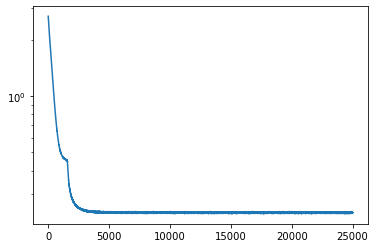

In [11]:
plt.yscale("log")
plt.plot(elbos)

In [14]:
test_ds = Dataset(
    dataset="FD001",
    split="test",
    normalization="min-max",
)
test_dl = DataLoader(
    test_ds,
    shuffle=False,
    num_workers=2,
    batch_size=1,
    pin_memory=True,
    persistent_workers=True,
)
error, loglh = 0.0, 0.0
with tyxe.poutine.flipout():
    for x, y in test_dl:
        #     e, llh = bnn.evaluate(
        #         x.to(DEVICE), y.to(DEVICE), num_predictions=20, reduction="mean"
        #     )
        #     print(e, x.item(), y.item())
        #     error += e
        #     loglh += llh
        m, sd = bnn.predict(x.to(DEVICE), num_predictions=100)
        print(m.item(), sd.item(), y.item())
# error, loglh

122.80438995361328 17.117097854614258 136.0
48.351009368896484 15.221590995788574 54.0
128.9730682373047 16.938833236694336 87.0
95.35614776611328 19.363683700561523 50.0
75.40257263183594 20.194316864013672 48.0
21.9544620513916 7.269348621368408 8.0
123.49494171142578 17.627540588378906 66.0
56.65050506591797 16.3779354095459 21.0
144.26414489746094 11.52216911315918 142.0
29.647132873535156 8.671462059020996 21.0
24.769723892211914 8.11141586303711 7.0
124.55364990234375 19.455060958862305 79.0
122.33447265625 17.72694206237793 57.0
140.71353149414062 12.181611061096191 137.0
29.850120544433594 9.933247566223145 10.0
110.37869262695312 20.098724365234375 95.0
22.91398048400879 6.639124870300293 11.0
34.10820388793945 9.497904777526855 38.0
108.23058319091797 18.787900924682617 106.0
132.0929412841797 15.992305755615234 137.0
61.54743576049805 13.895459175109863 55.0
42.70525360107422 12.23311710357666 50.0
29.202978134155273 8.656302452087402 28.0
139.56179809570312 12.6178092956542

In [15]:
error, loglh = 0.0, 0.0
with tyxe.poutine.local_reparameterization():
    for x, y in test_dl:
        #     e, llh = bnn.evaluate(
        #         x.to(DEVICE), y.to(DEVICE), num_predictions=20, reduction="mean"
        #     )
        #     print(e, x.item(), y.item())
        #     error += e
        #     loglh += llh
        m, sd = bnn.predict(x.to(DEVICE), num_predictions=100)
        print(m.item(), sd.item(), y.item())
# error, loglh

123.707763671875 16.69144630432129 136.0
52.00895309448242 13.92691421508789 54.0
132.649658203125 15.503509521484375 87.0
93.4935302734375 19.893396377563477 50.0
73.32384490966797 21.436540603637695 48.0
22.440780639648438 7.888374328613281 8.0
129.8683319091797 16.871736526489258 66.0
55.29474639892578 15.253477096557617 21.0
142.84312438964844 9.743876457214355 142.0
30.06807518005371 8.113990783691406 21.0
24.4930419921875 6.616991996765137 7.0
128.0994110107422 14.808327674865723 79.0
121.76078033447266 18.33889389038086 57.0
138.04718017578125 12.60719108581543 137.0
30.21173667907715 7.965590000152588 10.0
100.70728302001953 22.017250061035156 95.0
24.07122802734375 7.610478401184082 11.0
34.6567268371582 10.584359169006348 38.0
106.70845794677734 18.679723739624023 106.0
136.28109741210938 14.254150390625 137.0
61.82835006713867 18.2406063079834 55.0
45.818992614746094 12.033040046691895 50.0
31.96693992614746 10.735992431640625 28.0
136.06558227539062 13.822367668151855 121.0